In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer, get_weigts, plot_metrics)
#, transformer_estimator,residuals
from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn')

In [3]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


In [5]:
levels_type_house = data.type_house.unique()
levels_place = data.place.unique()
# levels_city_district = data.city_district.unique()
levels_list = [levels_place, levels_type_house]

cat_feat_df['n_levels'] = [levels_place, levels_type_house] #, levels_city_district
cat_feat_df['sample'] = [levels_place[:5], levels_type_house] #, levels_city_district[:4]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,place,"[nan, Naas, Wexford, Dublin 8, Dublin 6W, Carr...","[nan, Naas, Wexford, Dublin 8, Dublin 6W]"
1,type_house,"[house, nan, apartment]","[house, nan, apartment]"


In [6]:
features = [
    'price',
    'floor_area',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
    'type_house',
#    'city_district',
    'place']

data = data[features].copy()
data.shape

(7344, 8)

In [7]:
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 7)
y: (7344,)


# KMeans

In [8]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [38]:
num_pipe = Pipeline([
            ('power_transformer', StandardScaler()), #PowerTransformer(method='yeo-johnson')
            ('poly', PolynomialFeatures(degree=1, include_bias=False)),
            ('imputer', SimpleImputer(strategy='median')),
            ])
cat_pipe = Pipeline([
            ('one_hot_encoder', OneHotEncoder(categories=levels_list)), 
            ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
            ])
preprocessor = ColumnTransformer([
            ('num', num_pipe, num_features),
            ('cat', cat_pipe, cat_features),
            ])
pipe_estimator = Pipeline(steps=[
            ('preprocessor', preprocessor),
#            ('cluster', kmeans),
            ])

    
X_transformed = pipe_estimator.fit_transform(X)

In [39]:
X_transformed.shape

(7344, 145)

In [40]:
max_cluster = 10
inertia_dict = {}
for n_clusters in range(1, max_cluster + 1):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)  #, n_init=10  MiniBatchKMeans
    y_pred = kmeans.fit(X_transformed)
    
    inertia_dict[n_clusters] = kmeans.inertia_
    
    print(n_clusters)
    print(kmeans.inertia_)  
#    print(kmeans.score(X_transformed))
#    print(silhouette_score(X_transformed, kmeans.labels_)) 

1
46413.14705882353
2
35075.13554813272
3
29293.88518596474
4
26275.84414832758
5
23853.654244273497
6
22291.091241914586
7
21136.98263298985
8
20210.091614951838
9
19547.340245640422
10
19030.55322348103


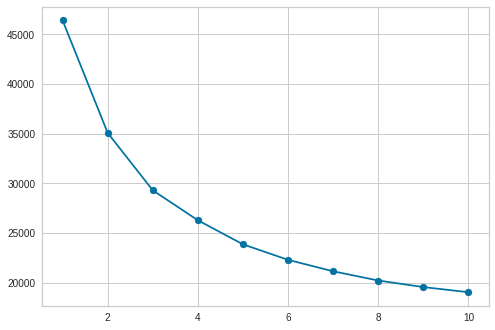

In [41]:
plt.scatter(x=inertia_dict.keys(), y=inertia_dict.values())
plt.plot(inertia_dict.keys(), inertia_dict.values())

In [42]:
# Number of maximum clusters tried 
max_cluster = 10
# Initialise dictionary 
sil_graph = {}
# Looping starting with 2 clusters and then
for cluster in range(2, max_cluster + 1):    
    # Calculate the kmeans with clusters
    kmeans = KMeans(n_clusters=cluster, random_state=7).fit(X_transformed)
    # Calculate the kmeans labels
    sil_graph[cluster] = silhouette_score(X_transformed, kmeans.labels_)
sil_graph

{2: 0.2338037149072909,
 3: 0.21190782169567746,
 4: 0.17450532010240033,
 5: 0.184088147933231,
 6: 0.17765342003071738,
 7: 0.15904038608783022,
 8: 0.1605345884532446,
 9: 0.15551206210836122,
 10: 0.14338679139308916}

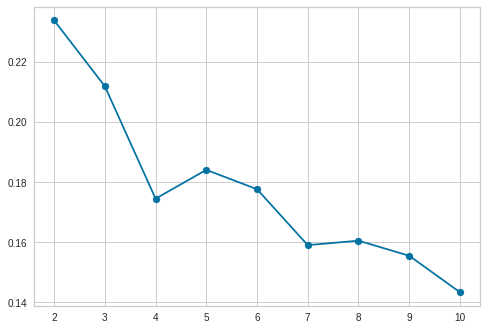

In [43]:
plt.scatter(x=sil_graph.keys(), y=sil_graph.values())
plt.plot(sil_graph.keys(), sil_graph.values())

In [44]:
kmeans = KMeans(n_clusters=2, random_state=7)
y_pred = kmeans.fit_predict(X_transformed)

kmeans.labels_

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [45]:
X['cluster'] = kmeans.labels_

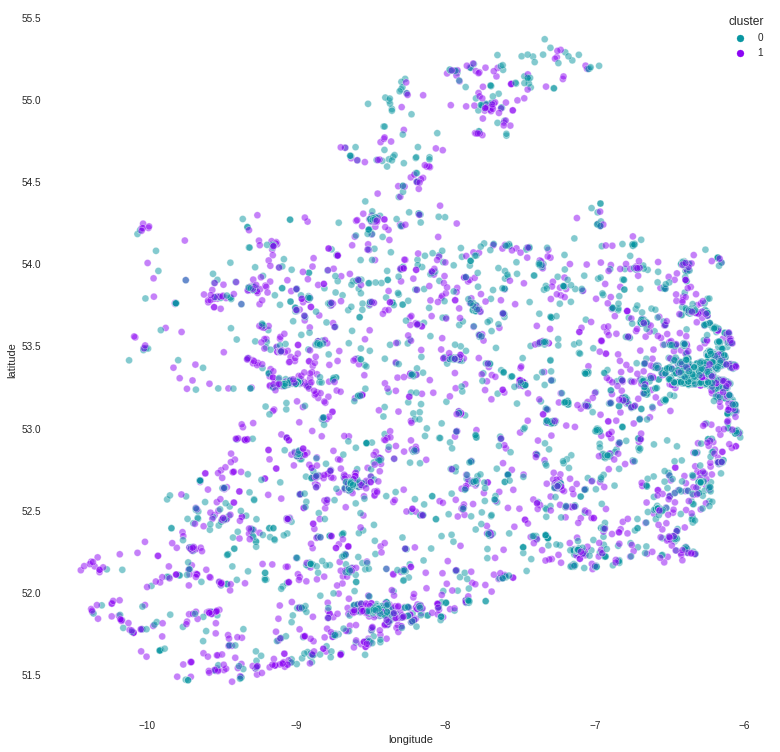

In [46]:
fig, ax = plt.subplots(figsize=(13, 13))

sns.scatterplot(data=X, x='longitude', y='latitude', 
                hue='cluster', ax=ax, 
                palette={-1:'red', 0:'#0896A1', 1:'#8C05F4', 2:'#EE0CBD',
                         3:'#0C15EE', 4:'#0CF631', 5:'#8C05F4', 6:'#8C05F4',
                         7:'red', 8:'#0896A1', 9:'black', 10:'yellow'
                        }, ##8C05F4
                alpha=.5, 
                #size='cluster'
               )  
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
ax.grid(visible=False)

In [47]:
from sklearn.decomposition import PCA

In [48]:
X_transformed

<7344x145 sparse matrix of type '<class 'numpy.float64'>'
	with 51408 stored elements in Compressed Sparse Row format>

In [49]:
pca = PCA(n_components=2)

X2D = pca.fit_transform(X_transformed.toarray())

In [50]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
# pca.components_

[0.3846949  0.20517559]
0.5898704947937361


In [51]:
X2D

array([[ 2.9824486 , -0.21223485],
       [ 0.86637362,  0.78673387],
       [-0.43104429, -0.25283466],
       ...,
       [ 2.71525116,  0.55073205],
       [ 1.45864721,  0.33723569],
       [ 0.90774109, -2.57819337]])

In [52]:
X2D[:, 0]

array([ 2.9824486 ,  0.86637362, -0.43104429, ...,  2.71525116,
        1.45864721,  0.90774109])

In [53]:
X2D = pd.DataFrame(X2D, columns=['PC1', 'PC2'])
X2D['cluster'] = kmeans.labels_
X2D.head()

,PC1,PC2,cluster
0,2.982449,-0.212235,1
1,0.866374,0.786734,1
2,-0.431044,-0.252835,0
3,1.103257,0.020487,1
4,-1.870085,0.552457,0


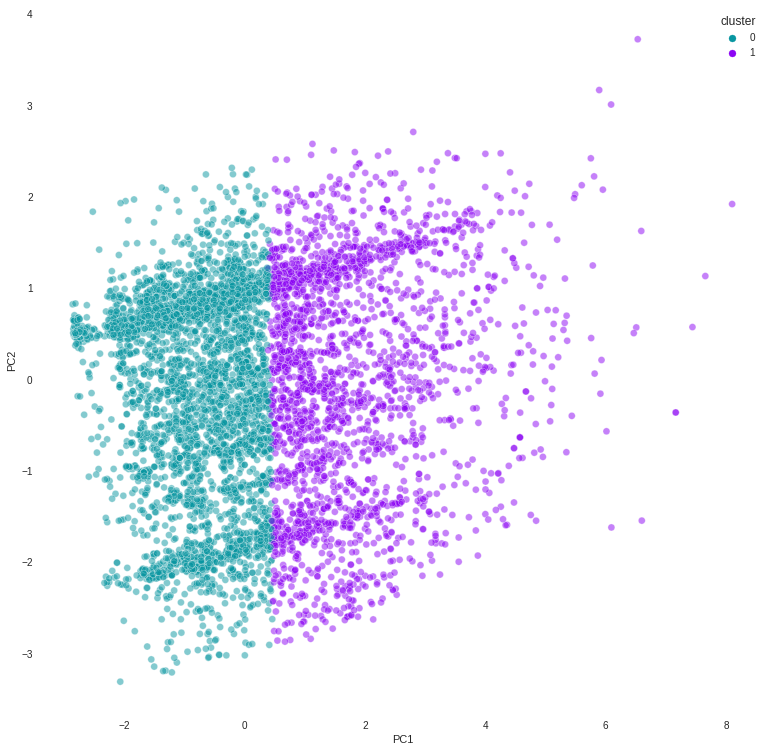

In [54]:
fig, ax = plt.subplots(figsize=(13, 13))

sns.scatterplot(data=X2D, x=X2D.PC1, y=X2D.PC2, 
                hue='cluster', 
                ax=ax, 
                palette={-1:'red', 0:'#0896A1', 1:'#8C05F4', 2:'#EE0CBD',
                         3:'#0C15EE', 4:'#0CF631', 5:'#8C05F4', 6:'#8C05F4',
                         7:'red', 8:'#0896A1', 9:'black', 10:'yellow'
                        }, ##8C05F4
                alpha=.5, 
                #size='cluster'
               )  
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
ax.grid(visible=False)

In [55]:
X_transformed.shape

(7344, 145)

In [56]:
pca = PCA(n_components=3)

X3D1 = pca.fit_transform(X_transformed.toarray())

X3D1 = pd.DataFrame(X3D1, columns=['PC1', 'PC2', 'PC3'])
X3D1['cluster'] = kmeans.labels_
X3D1.head()

,PC1,PC2,PC3,cluster
0,2.982449,-0.212235,1.220700,1
1,0.866374,0.786734,-0.452357,1
2,-0.431044,-0.252835,-1.319777,0
3,1.103257,0.020487,-1.400499,1
4,-1.870085,0.552457,-0.255904,0


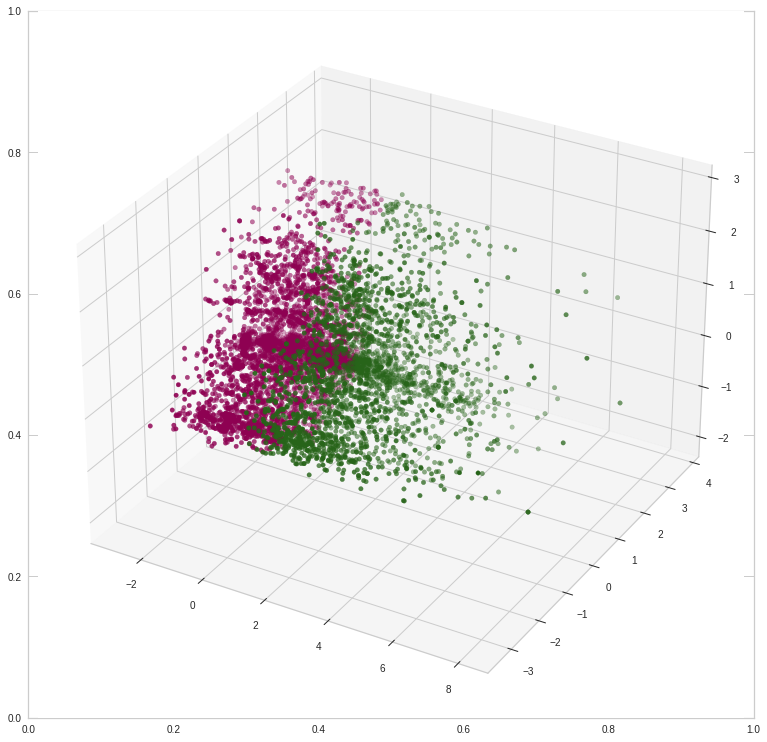

In [121]:
fig, ax = plt.subplots(figsize=(13, 13))
ax = plt.axes(projection='3d')

#my_cmap = plt.get_cmap('hsv')

ax.scatter3D(X3D1.PC1, X3D1.PC2, X3D1.PC3,# colormap={0:'red', 1:'blue'}
             c=X3D1.cluster, cmap='PiYG'
            );

In [120]:
import plotly.express as px

fig = px.scatter_3d(X3D1, x=X3D1.PC1, y=X3D1.PC2, z=X3D1.PC3,
                    color=X3D1.cluster, 
               #     size=X3D1.cluster, 
               #     size_max=10,
                    opacity=0.8,
              #      color_continuous_scale=px.colors.diverging.PiYG,
                 #   color_discrete_sequence=px.colors.sequential.Plotly3
                   color_continuous_scale=px.colors.diverging.PiYG, 
                    height=700
                   )
fig.update_traces(marker_size = 4)
#fig.show()

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# DBSCAN

In [59]:
X_transformed.shape, y.shape

((7344, 145), (7344,))

In [60]:
from sklearn.cluster import DBSCAN

In [61]:
epsilon = .43

dbscan = DBSCAN(eps=epsilon, min_samples=7).fit(X_transformed)

print((pd.Series(list(dbscan.labels_)) == -1).sum())
pd.Series(list(dbscan.labels_)).unique()

4997


array([ -1,   0, 170,   1,   2,   3,   4, 185,   5, 181,   6,   7,   8,
        51,   9,  10,  11,  12,  15,  13,  14,  16,  17,  18,  19, 158,
        20,  21,  96, 183,  22, 150, 188,  23,  24,  25, 160,  26,  27,
        28,  29,  30,  31,  32,  33, 179,  34,  35,  36,  37, 140,  38,
        39,  40,  41,  42,  43,  44,  45,  46, 134,  47, 167,  48,  49,
        50,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        89,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74, 113,
        75, 195, 172,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86, 156,  87,  88,  90,  91,  92,  93,  94,  95,  97,  98,  99,
       100, 101, 102, 103, 186, 104, 105, 106, 164, 107, 108, 171, 109,
       110, 111, 112, 114, 115, 116, 117, 139, 147, 118, 194, 189, 119,
       120, 162, 121, 122, 123, 124, 130, 125, 193, 126, 127, 196, 128,
       129, 131, 132, 133, 135, 136, 137, 138, 191, 141, 142, 143, 144,
       159, 190, 145, 146, 148, 149, 151, 152, 169, 153, 154, 15

In [62]:
# Indices of the core components
dbscan.core_sample_indices_

array([   1,    4,    7, ..., 7244, 7247, 7249])

In [63]:
# Core components
dbscan.components_

<1945x145 sparse matrix of type '<class 'numpy.float64'>'
	with 13615 stored elements in Compressed Sparse Row format>

In [64]:
dbscan

DBSCAN(eps=0.43, min_samples=7)

In [65]:
len(dbscan.labels_)

7344

In [66]:
X.shape

(7344, 8)

In [67]:
X['cluster'] = dbscan.labels_
X.shape

(7344, 8)

In [70]:
pca = PCA(n_components=3)

X3D2 = pca.fit_transform(X_transformed.toarray())

X3D2 = pd.DataFrame(X3D2, columns=['PC1', 'PC2', 'PC3'])
X3D2['cluster'] = dbscan.labels_
X3D2.head()

,PC1,PC2,PC3,cluster
0,2.982449,-0.212235,1.220700,-1
1,0.866374,0.786734,-0.452357,0
2,-0.431044,-0.252835,-1.319777,-1
3,1.103257,0.020487,-1.400499,170
4,-1.870085,0.552457,-0.255904,1


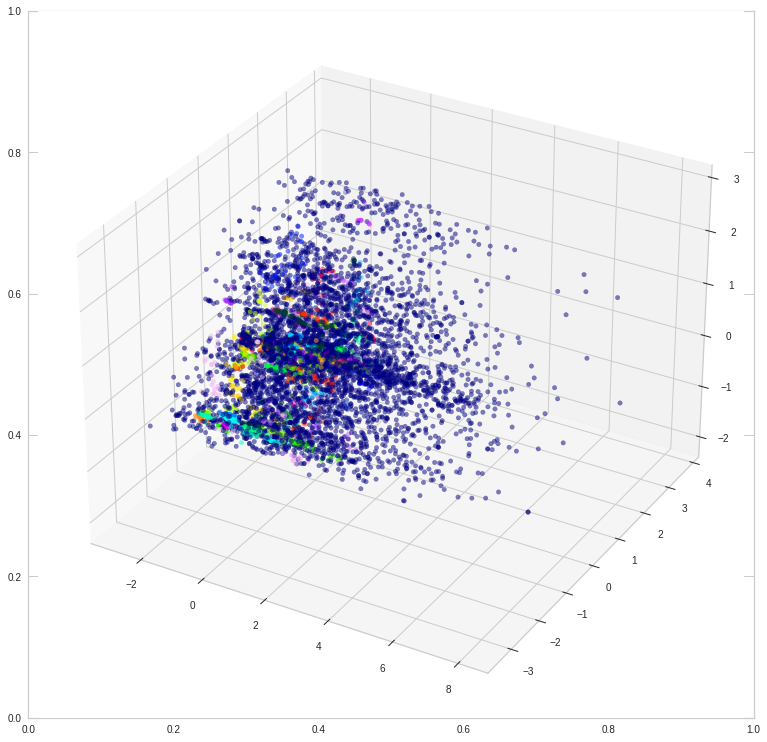

In [123]:
fig, ax = plt.subplots(figsize=(13, 13))
ax = plt.axes(projection='3d')

#my_cmap = plt.get_cmap('hsv')

ax.scatter3D(X3D2.PC1, X3D2.PC2, X3D2.PC3,# colormap={0:'red', 1:'blue'}
             c=X3D2.cluster, cmap='gist_ncar', alpha=.5   #gist_ncar
            );

In [126]:
fig = px.scatter_3d(X3D1, x=X3D2.PC1, y=X3D2.PC2, z=X3D2.PC3,
                    color=X3D2.cluster, 
               #     size=X3D1.cluster, 
               #     size_max=10,
                    opacity=0.8,
              #      color_continuous_scale=px.colors.diverging.PiYG,
                 #   color_discrete_sequence=px.colors.sequential.Plotly3
             #      color_continuous_scale=px.colors.diverging.PiYG, 
                    color_continuous_scale=px.colors.sequential.Rainbow, 
                    height=600
                   )
fig.update_traces(marker_size = 4)
#fig.show()

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))